In [1]:
#What i want this notebook to do is to find the coherence and the power over the whole session, 
#and then be able to mask them based on trial times. 
#in the end, give which trial i want, and then make subplot with lfp, theta, speed, coherence, and power spectra. 


In [40]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

In [3]:
nwb_file_name = 'senor20201030_.nwb'

In [4]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'
trial_data = pd.read_csv(filename)
trial_data

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf4,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#only look at one session 
trial_data_sesh = trial_data[trial_data.epoch==2]

In [6]:
#this will label trials where he is ABOUT to stem switch. the trial before stem switch, stem switch=true. 

trial_data_sesh['stem_switch'] = trial_data_sesh['stem'].ne(trial_data_sesh['stem'].shift())

for ix in range(len(trial_data_sesh)):
    if trial_data_sesh.loc[ix,'trial_number_by_epoch']==0:
        trial_data_sesh.loc[ix,'stem_switch']= True
trial_data_sesh['stem_switch']=trial_data_sesh['stem_switch'].shift(-1)        
trial_data_sesh

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [32]:
# theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])
theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type = ['Theta 5-11 Hz'], data_type = ['theta'])



position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()

In [33]:
#This will find the length of the session by using the trial times in the data. probably not the best way to do this! how to grab the whole session times?
num_secs_to_get = int(trial_data_sesh.iloc[-1].poke_out_ts - trial_data_sesh.iloc[0].poke_in_ts-1)
num_secs_to_get

1144

In [38]:
electrode_id = [17,40,132,300]
time_from_start = 200 #in seconds
time_interval_s = 1000
sampling_rate_lfp = 1000
epoch = (IntervalList & {'nwb_file_name':nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)
x_elect_lfp, y_elect_lfp = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_theta, y_elect_theta = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)



6.0


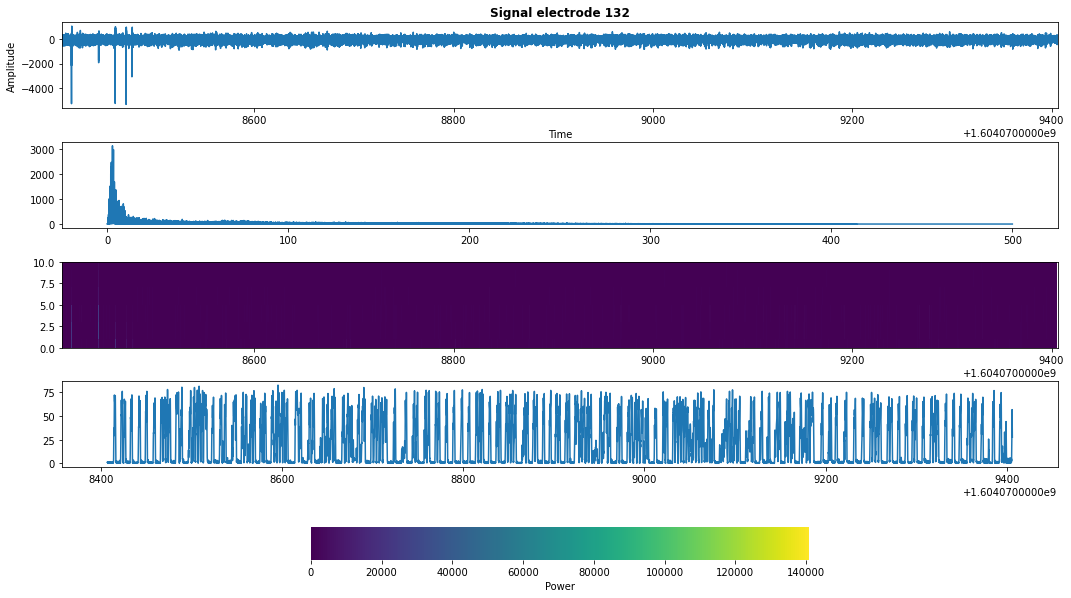

In [39]:
# frequency_of_interest = [200, 50]
electrode_ix1= 2

sampling_frequency = 1000
time_halfbandwidth_product = 1.5

time_data = x_elect_lfp[electrode_ix1]
signal = y_elect_lfp[electrode_ix1]
noise = np.zeros(len(x_elect_lfp[electrode_ix1]))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 9))
axes[0].plot(time_data, signal)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Signal electrode {electrode_id[electrode_ix1]}', fontweight='bold')
axes[0].set_xlim(time_data[0], time_data[-1])



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               # time_window_duration=.6,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies)
axes[1].plot(c.frequencies, c.power().squeeze())


m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=.5,
               time_window_step=None,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
mesh = axes[2].pcolormesh(c.time, c.frequencies, c.power().squeeze().T,
                            cmap='viridis')
axes[2].set_ylim((0, 10))
axes[2].set_xlim(time_data[0], time_data[-1])



plt.tight_layout()

cb = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation='horizontal',
                  shrink=.5, aspect=15, pad=0.1, label='Power')
cb.outline.set_linewidth(0)

axes[3].plot(x_pos,y_pos)
# axes[3].set_xlim(time_data[0], time_data[-1])


print(m.frequency_resolution)

#cut off color spectrum thing at 600 or something to see smaller differences 